In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import clean_reports
import preprocess_reports
from nltk.tokenize import word_tokenize

from sentence_transformers import SentenceTransformer

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## EDA Data Cleaning

In [2]:
##from sentence_transformers import SentenceTransformer. # will be used for the bert transformer in the future
# dataset location
DATASET = "/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/Data/prospect-data.csv"
print("Dataset saved as DATASET")

# load dataset into dataframe
data = clean_reports.clean(DATASET, raw=True)

data.head()
DATASET=data

#
DATASET2023=data[data['Year'] == 2023]
DATASET2022=data[data['Year'] ==2022]
DATASET2021=data[data['Year'] == 2021]

Dataset saved as DATASET


-----------------
For All Data


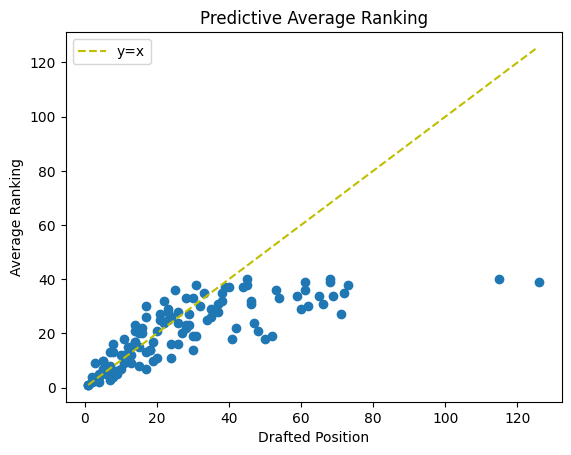

None
-----------------
For 2022


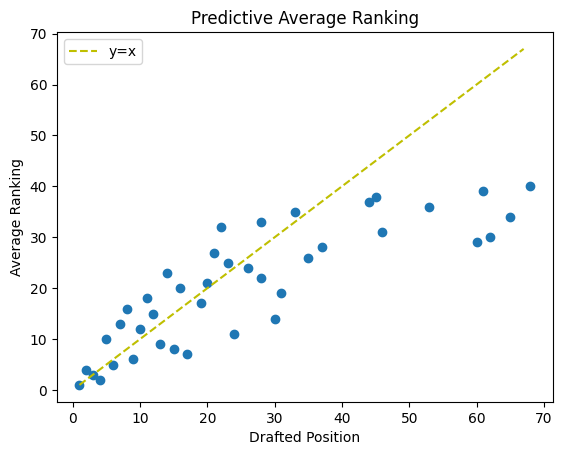

None
-----------------
For 2021


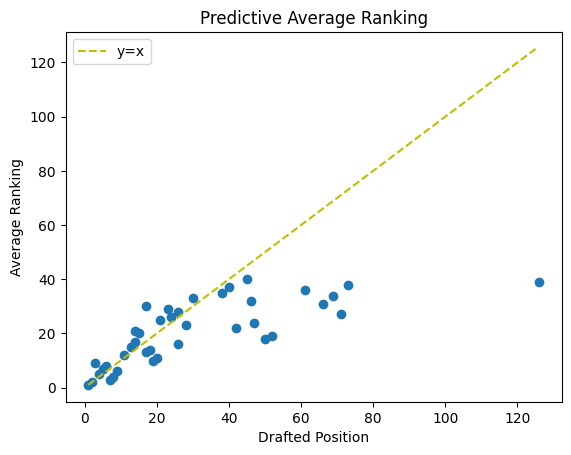

None


In [3]:
def plot_drafted_vs_ranking(data):
    # Create the x-values range from the minimum to the maximum 'Drafted' position
    x = np.arange(data['Drafted'].min(), data['Drafted'].max())     #creates an array of evenly spaced values from min ranked position to max pos
    y = x

    # Scatter plot of 'Drafted' vs 'Average Ranking'
    plt.scatter(data['Drafted'], data['Average Ranking'])

    # Plot a reference line y=x
    plt.plot(x, y, 'y--', label="y=x")
    
    plt.xlabel("Drafted Position")
    plt.ylabel("Average Ranking")
    plt.legend()
    plt.title("Predictive Average Ranking")
    plt.show()

# Now you can call the function with the data you have
print("-----------------")
print("For All Data")
print(plot_drafted_vs_ranking(DATASET))
print("-----------------")
print("For 2022")
print(plot_drafted_vs_ranking(DATASET2022))
print("-----------------")
print("For 2021")
print(plot_drafted_vs_ranking(DATASET2021))

In [4]:
HOCKEY_POSITIONS = {
    'C' : 'Center',
    'D' : 'Defender',
    'RW' : 'Right Wing',
    'LW' : 'Left Wing',
    'G' : 'Goalie'
}

# distribution of player positions
data['Position'].value_counts()

Position
C     134
D     116
RW     78
LW     60
G      14
Name: count, dtype: int64

In [5]:
# Identify scouting report columns
match = data.columns.str.match('Description')
scouting_reports = data.columns[match]

# Create a deep copy of the DataFrame
token_count = data.copy(deep=True)

# Define a function to count tokens (words) using split
def count_tokens(text):
    if isinstance(text, str):
        # Split the string by spaces and count the number of words
        return len(text.split())
    else:
        return np.nan

# Apply the function across all scouting report columns
token_count[scouting_reports] = token_count[scouting_reports].applymap(count_tokens)

# Calculate the average token count for each scouting report column
average_token_count = token_count[scouting_reports].mean().sort_values()

# Display the result
print(average_token_count)

Description - EP Rinkside             79.006329
Description - The Painted Lines      129.969925
Description - ESPN (Chris Peters)    134.960699
Description - Corey Pronman          154.087404
Description - Smaht Scouting         215.127517
Description - Scott Wheeler          230.403756
Description - FCHockey               328.971429
Description - EP Rinkside Part 2     409.613757
dtype: float64


/var/folders/53/kssq81zs06d17_l658v4lbnm0000gn/T/ipykernel_46908/1730023739.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  token_count[scouting_reports] = token_count[scouting_reports].applymap(count_tokens)


In [6]:
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('all-mpnet-base-v2')

/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


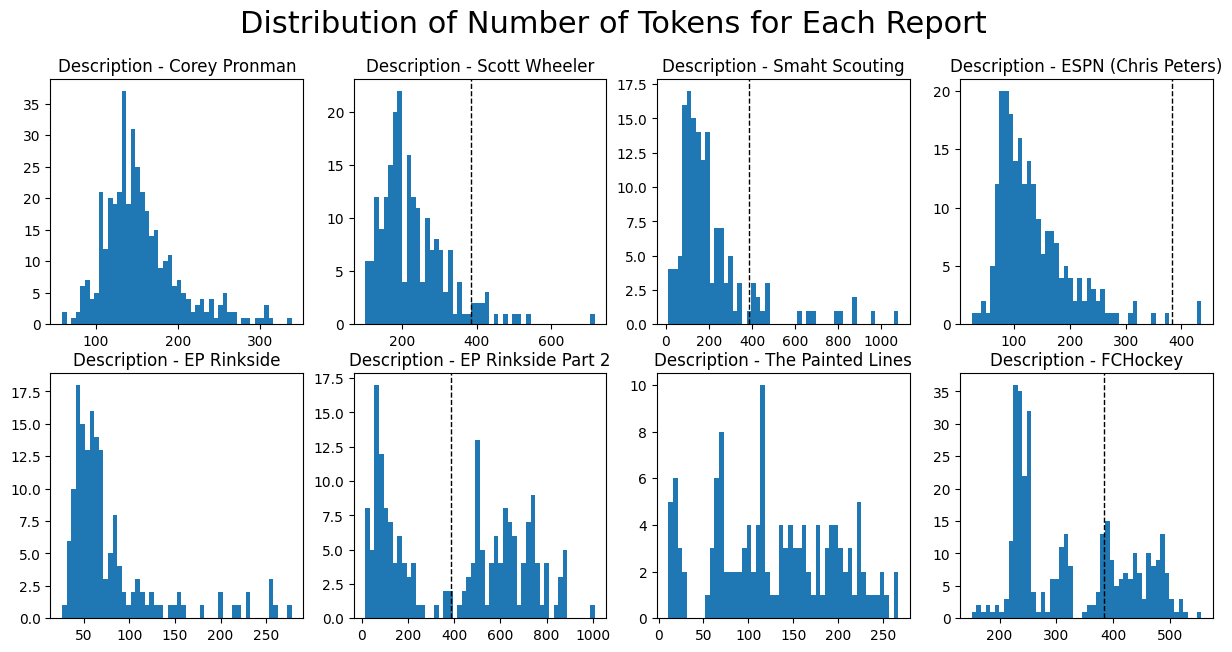

In [7]:
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))

for index, report in enumerate(scouting_reports):
    xx = token_count[report].values  
    i, j = [array[0] for array in np.unravel_index([index], shape=(nrows,ncols))] 
    
    ax[i, j].hist(xx, bins=50) 
    ax[i, j].set_title(report)  
    
    if xx[~np.isnan(xx)].max() > bert_model.max_seq_length:
        ax[i, j].axvline(bert_model.max_seq_length, color='k', linestyle='dashed', linewidth=1)  # Add vertical line

plt.suptitle("Distribution of Number of Tokens for Each Report", fontsize=22)
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 42 to 401
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               360 non-null    int64  
 1   Position                           360 non-null    object 
 2   Height                             360 non-null    float64
 3   Weight                             360 non-null    float64
 4   Drafted                            360 non-null    float64
 5   Team                               360 non-null    object 
 6   Average Ranking                    120 non-null    float64
 7   Name                               360 non-null    object 
 8   Description - Corey Pronman        347 non-null    object 
 9   Description - Scott Wheeler        171 non-null    object 
 10  Description - Smaht Scouting       107 non-null    object 
 11  Description - ESPN (Chris Peters)  187 non-null    object 
 12

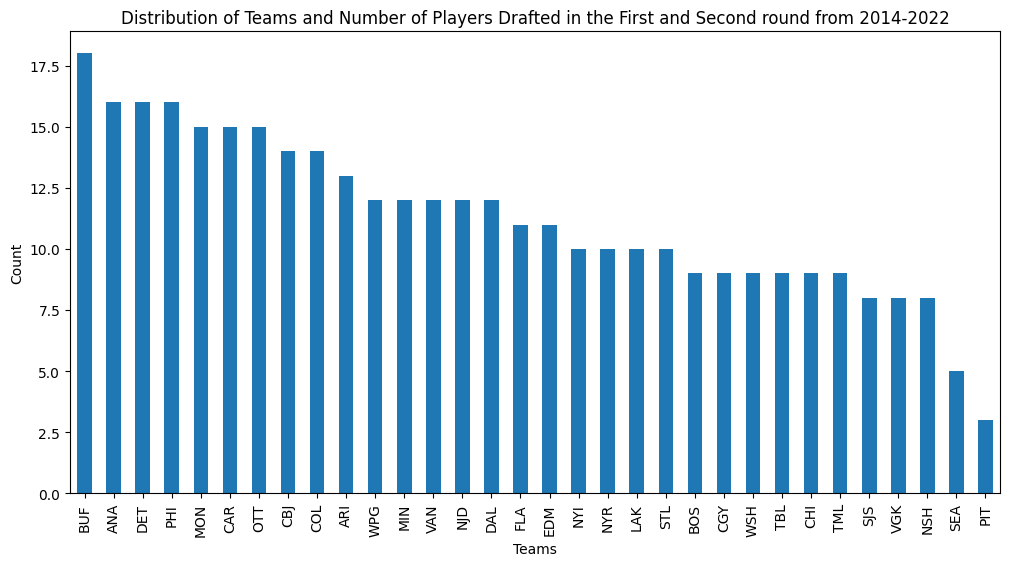

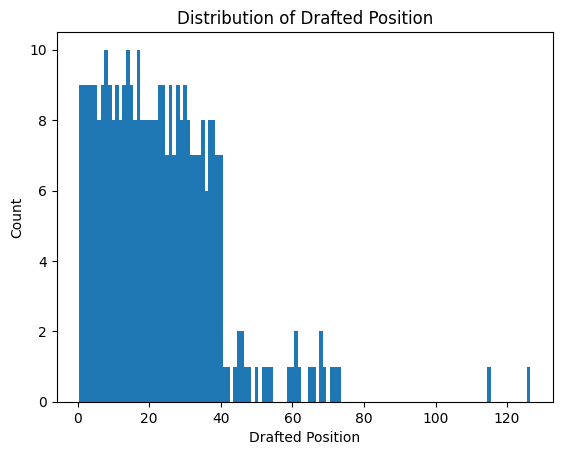

In [8]:
#data = data[data['Team'] != 'SEA'] #seattle is a new team as of 2021 having a 2021 second overall pick

# keep data only to 2014-2022 (predict this year's class at a later time)
data = data[data['Year'] <= 2022]

data.info()

# check the histogram distribution of teams
import matplotlib.pyplot as plt

# Filter out Seattle team and keep data only from 2014 to 2022
#data = data[data['Team'] != 'SEA']
data = data[data['Year'] <= 2022]

# Plot the distribution of the 'Teams' column
plt.figure(figsize=(12, 6))
data['Team'].value_counts().plot(kind='bar')
plt.title('Distribution of Teams and Number of Players Drafted in the First and Second round from 2014-2022')
plt.xlabel('Teams')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


# check the histogram distribution of draft position
x = data.groupby('Drafted').count().index
height = data.groupby('Drafted').count().iloc[:,0]
plt.bar(x, height,width=1.0)
plt.title('Distribution of Drafted Position')
plt.xlabel('Drafted Position')
plt.ylabel('Count')
plt.show()

## Bert Transformations


In [9]:
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer

In [11]:
import nltk
preprocessed_df = data.copy()
long_df = preprocessed_df.melt(
    id_vars=['Year', 'Position', 'Height', 'Weight', 'Drafted', 'Team', 'Average Ranking', 'Name'],
    value_vars=scouting_reports.tolist(),
    var_name='reporter',  
    value_name='text'
).dropna(
    subset=['text']
)

preprocessed_df.head(3)

HOCKEY_WORDS = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "chl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "liiga", 
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "saginaw", "kelowna", "frolunda",
                "slovakia"]

nltk.download('punkt_tab')

# scouting report columns
mask = data.columns.str.match('Description')
scouting_reports = data.columns[mask]

# preprocess data with NLTK
preprocessed_df = data.copy()
for report in scouting_reports:
    report_preprocessor = preprocess_reports.NltkPreprocessor(data[report])
    preprocessed_df.loc[:, report] = report_preprocessor\
        .remove_names(data['Name'])\
        .remove_whitespace()\
        .remove_words(HOCKEY_WORDS)\
        .get_text()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [12]:
# transform from wide to long data frame
long_df = preprocessed_df.melt(
    id_vars=['Year', 'Position', 'Height', 'Weight', 'Drafted', 'Team', 'Average Ranking', 'Name'],
    value_vars=scouting_reports.tolist(),
    var_name='reporter',  
    value_name='text'
).dropna(
    subset=['text']
)

print(long_df.head(3))


   Year Position  Height  Weight  Drafted Team  Average Ranking  \
0  2022       LW    76.0   218.0      1.0  MON              1.0   
1  2022        C    72.5   193.0      4.0  SEA              2.0   
2  2022        D    72.0   190.0      2.0  NJD              4.0   

               Name                     reporter  \
0  Juraj Slafkovsky  Description - Corey Pronman   
1      Shane Wright  Description - Corey Pronman   
2       Simon Nemec  Description - Corey Pronman   

                                                text  
0  has all the assets you 're looking for in a to...  
1  is a very well-rounded who has no noticeable f...  
2  is a very well-rounded defenseman . His puck g...  


In [13]:
bert_embeddings_path = '/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/Data/reports_with_bert_embeddings.csv'
if not os.path.exists(bert_embeddings_path):
    # get bert embeddings now, so we don't have to redo it for
    # each fit during GridSearch
    bert_model = SentenceTransformer('all-mpnet-base-v2')

    bert_embeddings = bert_model.encode(long_df['text'].ravel())

    bert_columns = [f'bert{i}' for i in range(bert_embeddings.shape[1])]
    bert_df = pd.DataFrame(bert_embeddings, columns=bert_columns)

    long_df = long_df.join(bert_df, on=long_df.index)

    with open(bert_embeddings_path, 'w') as write_file:
        long_df.to_csv(write_file)
else:
    long_df = pd.read_csv(bert_embeddings_path)

    bert_columns = long_df.columns[long_df.columns.str.match('^bert')].tolist()

## Setting Up Predictor

In [14]:
import setup_predictor
import importlib
importlib.reload(setup_predictor)
from Model import LogisticOrdinalRegression, SVMOrdinalClassifier, MLPOrdinalClassifier, RandomForestOrdinalClassifier
from sklearn.impute import SimpleImputer

# setup model architecture
numeric_cols = ['Height', 'Weight'] + bert_columns
categorical_cols = ['Position', 'reporter']

# text_cols = scouting_reports.tolist()
text_cols = []
lr_model = setup_predictor.setup(
    numeric_cols=numeric_cols, 
    categorical_cols=categorical_cols,
    text_cols=text_cols,
    func=LogisticOrdinalRegression()
)

svm_model = setup_predictor.setup(
    numeric_cols=numeric_cols, 
    categorical_cols=categorical_cols,
    text_cols=text_cols,
    func=SVMOrdinalClassifier()
)

mlp_model = setup_predictor.setup(
    numeric_cols=numeric_cols, 
    categorical_cols=categorical_cols,
    text_cols=text_cols,
    func=MLPOrdinalClassifier()
)

rf_model = setup_predictor.setup(
    numeric_cols=numeric_cols, 
    categorical_cols=categorical_cols,
    text_cols=text_cols,
    func=RandomForestOrdinalClassifier()
)


In [15]:
X = long_df[numeric_cols + categorical_cols + text_cols]
y = long_df['Drafted']
groups = long_df['Name']

mean_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])
std_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])

In [16]:
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from Model import *
from train_test_predictor import train_and_test

This code below sets up a logistic regression model and uses a grid search to tune its hyperparameters. The param_grid specifies the values for regularization (penalty), the regularization strength (C), and the solver (liblinear). The model is trained and evaluated using the train_and_test function, which performs cross-validation to assess the model's performance.

The results, including performance metrics, are stored in lr_metrics. 

The mean and standard deviation of the metrics are then computed and saved to two DataFrames (mean_df and std_df), labeled with the model type (BERT_log_reg). This allows easy comparison of the model's performance with other models.

### Linear Regression Model

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from Model import LogisticOrdinalRegression

# Define the logistic ordinal regression model
lor_model = LogisticOrdinalRegression()

# Define the parameter grid
param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': np.logspace(-4, 4, 20).tolist(),
    'model__solver': ['liblinear'],
}

# Define the categorical columns
categorical_cols = ['Position', 'reporter']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), list(set(X.columns) - set(categorical_cols)))
    ],
    remainder='passthrough'
)

# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lor_model)
])

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X, y)

# Get the best estimator
best_model = grid_search.best_estimator_

# Calculate mean and standard deviation of metrics
lor_metrics = {
    'accuracy': grid_search.cv_results_['mean_test_score'],
    'std_accuracy': grid_search.cv_results_['std_test_score']
}

# Store the results in DataFrames
mean_df = pd.DataFrame({
    'accuracy': lor_metrics['accuracy'],
    'C': grid_search.cv_results_['param_model__C'],
    'penalty': grid_search.cv_results_['param_model__penalty'],
    'solver': grid_search.cv_results_['param_model__solver']
})

std_df = pd.DataFrame({
    'std_accuracy': lor_metrics['std_accuracy'],
    'C': grid_search.cv_results_['param_model__C'],
    'penalty': grid_search.cv_results_['param_model__penalty'],
    'solver': grid_search.cv_results_['param_model__solver']
})

# Display the results
print("Mean Metrics:")
print(mean_df)
print("\nStandard Deviation Metrics:")
print(std_df)

/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
  0%|          | 0/63 [00:00<?, ?it/s]/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jeremygonsalves/Documents/GitHub

Mean Metrics:
    accuracy             C penalty     solver
0   0.000000      0.000100      l1  liblinear
1   0.028640      0.000100      l2  liblinear
2   0.000000      0.000264      l1  liblinear
3   0.041375      0.000264      l2  liblinear
4   0.017187      0.000695      l1  liblinear
5   0.040099      0.000695      l2  liblinear
6   0.017824      0.001833      l1  liblinear
7   0.038831      0.001833      l2  liblinear
8   0.020362      0.004833      l1  liblinear
9   0.032462      0.004833      l2  liblinear
10  0.014631      0.012743      l1  liblinear
11  0.035008      0.012743      l2  liblinear
12  0.024196      0.033598      l1  liblinear
13  0.029281      0.033598      l2  liblinear
14  0.026725      0.088587      l1  liblinear
15  0.026096      0.088587      l2  liblinear
16  0.016546      0.233572      l1  liblinear
17  0.025460      0.233572      l2  liblinear
18  0.019088      0.615848      l1  liblinear
19  0.026733      0.615848      l2  liblinear
20  0.015274      1.

### Random Forest Model

In [18]:
from Model import RandomForestOrdinalClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Prepare your dataset
X = long_df[numeric_cols + categorical_cols + text_cols]
y = long_df['Drafted']
groups = long_df['Name']

# Define the categorical columns
categorical_cols = ['Position', 'reporter']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numeric_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestOrdinalClassifier())
])

# Initialize the dataframes to store results
mean_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])
std_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted')
}

# Store the results in dataframes
mean_df.loc['RandomForestOrdinal'] = pd.Series(metrics)
std_df.loc['RandomForestOrdinal'] = pd.Series({k: 0 for k in metrics})  # Placeholder for std deviation

# Print the results
print("Mean Metrics:")
print(mean_df)
print("\nStandard Deviation Metrics:")
print(std_df)

  5%|▍         | 3/63 [00:35<12:07, 12.12s/it]

100%|██████████| 63/63 [09:43<00:00,  9.26s/it]


Mean Metrics:
                     accuracy        f1  precision   recall
RandomForestOrdinal   0.02799  0.027986   0.028535  0.02799

Standard Deviation Metrics:
                     accuracy  f1  precision  recall
RandomForestOrdinal         0   0          0       0


/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Support Vector Machine

In [19]:
from Model import SVMOrdinalClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Ensure your dataset and columns are defined
assert 'long_df' in globals(), "long_df is not defined"
assert 'numeric_cols' in globals(), "numeric_cols is not defined"
assert 'categorical_cols' in globals(), "categorical_cols is not defined"
assert 'text_cols' in globals(), "text_cols is not defined"

# Prepare your dataset
X = long_df[numeric_cols + categorical_cols + text_cols]
y = long_df['Drafted']
groups = long_df['Name']

# Define the categorical columns
categorical_cols = ['Position', 'reporter']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numeric_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVMOrdinalClassifier())
])

# Initialize the dataframes to store results
mean_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])
std_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

try:
    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted')
    }

    # Store the results in dataframes
    mean_df.loc['SVMOrdinal'] = pd.Series(metrics)

    # Calculate standard deviation of metrics using cross-validation
    cv_results = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    std_metrics = {
        'accuracy': cv_results.std(),
        'f1': cross_val_score(pipeline, X, y, cv=5, scoring='f1_weighted').std(),
        'precision': cross_val_score(pipeline, X, y, cv=5, scoring='precision_weighted').std(),
        'recall': cross_val_score(pipeline, X, y, cv=5, scoring='recall_weighted').std()
    }

    std_df.loc['SVMOrdinal'] = pd.Series(std_metrics)

    # Print the results
    print("Mean Metrics:")
    print(mean_df)
    print("\nStandard Deviation Metrics:")
    print(std_df)

except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: sklearn.svm._classes.SVC() got multiple values for keyword argument 'probability'


## Machine Learning Propogation MLP

In [ ]:
from Model import MLPOrdinalClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Ensure your dataset and columns are defined
assert 'long_df' in globals(), "long_df is not defined"
assert 'numeric_cols' in globals(), "numeric_cols is not defined"
assert 'categorical_cols' in globals(), "categorical_cols is not defined"
assert 'text_cols' in globals(), "text_cols is not defined"

# Prepare your dataset
X = long_df[numeric_cols + categorical_cols + text_cols]
y = long_df['Drafted']
groups = long_df['Name']

# Define the categorical columns
categorical_cols = ['Position', 'reporter']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numeric_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', MLPOrdinalClassifier())
])

# Initialize the dataframes to store results
mean_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])
std_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 'recall'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

try:
    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted')
    }

    # Store the results in dataframes
    mean_df.loc['MLPOrdinal'] = pd.Series(metrics)

    # Calculate standard deviation of metrics using cross-validation
    cv_results = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    std_metrics = {
        'accuracy': cv_results.std(),
        'f1': cross_val_score(pipeline, X, y, cv=5, scoring='f1_weighted').std(),
        'precision': cross_val_score(pipeline, X, y, cv=5, scoring='precision_weighted').std(),
        'recall': cross_val_score(pipeline, X, y, cv=5, scoring='recall_weighted').std()
    }

    std_df.loc['MLPOrdinal'] = pd.Series(std_metrics)

    # Print the results
    print("Mean Metrics:")
    print(mean_df)
    print("\nStandard Deviation Metrics:")
    print(std_df)

except Exception as e:
    print(f"An error occurred: {e}")